# __ACA dark current map - simulations__

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
import astropy.units as u
from kadi import events
from mica.archive import aca_l0
import Ska.engarchive.fetch as fetch
from chandra_aca import transform
from Chandra.Time import DateTime
import Ska.Numpy
from mica import quaternion
import numpy.ma as ma
import collections
from Ska.Matplotlib import plot_cxctime

### Contents ###

* Simulate <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither.
* Compute background image based on edge pixel values sampled by dither.
* Simulate telemetry in <code>aca_l0</code> format.
* Dark current map.
* Centroids.
* Plotting functions.
* Examples: simulated case and real data.

### <code>IMGROW0</code>, <code>IMGCOL0</code> response to dither###

<code>IMGROW0</code> and <code>IMGCOL0</code> respond to the dither pathern (yaw, pitch). Here this response is defined so that the difference between yaw and <code>IMGROW0</code>, and pitch and <code>IMGCOL0</code> is always < 1 pixel to keep star image near the center of the 8x8 window.

Below, this algorithm is checked against real data (obsid 50804).

In reality, this response depends likely on the next anticipated centroid values because <code>IMGROW0</code>, <code>IMGCOL0</code> time behaviour is not identical for all slots.

In [2]:
obsid = 50804
slot = 3
dwell = events.dwells.filter(obsid=obsid)[0]
slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
time = slot_data['TIME']
row0 = slot_data['IMGROW0']
col0 = slot_data['IMGCOL0']

In [3]:
# Dither parameters
ampl = 8. * u.arcsec
pxsize = 5. * u.arcsec # per pixel
yaw_period = 1000.0 # sec
pitch_period = 707.1 # sec

# "Fit" parameters (depend on obsid and slot)
delta_yaw = 99.9
delta_pitch = 300.1
delta = 0.25 # px

pitch = ampl / pxsize * np.sin(2 * np.pi * time / pitch_period + delta_pitch)
yaw = ampl / pxsize * np.sin(2 * np.pi * time / yaw_period + delta_yaw)

sim_row0 = np.array(np.round(yaw - delta), dtype=np.int)
sim_col0 = np.array(np.round(pitch - delta), dtype=np.int)

print np.sum(yaw - sim_row0 > 1), np.sum(pitch - sim_col0 > 1)

0 0


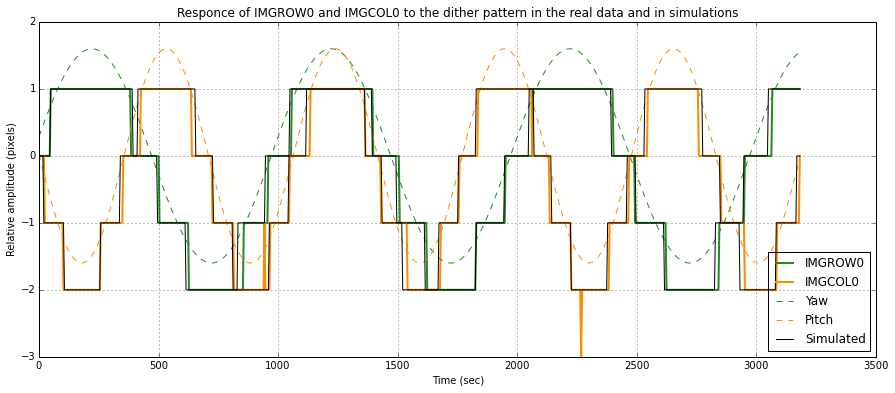

In [4]:
plt.figure(figsize=(15, 6))

plt.plot(time - time[0], row0 - row0[0], 'forestgreen', lw=2, label='IMGROW0')
plt.plot(time - time[0], col0 - col0[0], 'darkorange', lw=2, label='IMGCOL0')
plt.plot(time - time[0], yaw, 'forestgreen', ls='--', label='Yaw')
plt.plot(time - time[0], pitch, 'darkorange', ls='--', label='Pitch')

plt.plot(time - time[0], sim_row0, 'k')
plt.plot(time - time[0], sim_col0, 'k', label='Simulated')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel("Time (sec)")
plt.ylabel("Relative amplitude (pixels)")
plt.title('Responce of IMGROW0 and IMGCOL0 to the dither pattern in the real data and in simulations')

### Construct background image using sampled edge pixel values###

Compute background image for each time frame. Considered cases include:

* Current algorithm: assign average background value telemetered in <code>aca_l0</code> to each pixel, independantly of its real value (<code>bgd = 'bgdavg'</code>).


* Store the real value of each sampled edge pixel, and telemetered average background value for the remaining pixels. Use the median of n stored values for each pixel to compute the current background image (<code>bgd = 'mixed'</code>).

    1. __Patch S/ Survey.__ Use n "searches" to identify hot pixels and build a background map with hot pixels. Use this map when subtracting background from each time frame.
    
    1. __Patch D/ Dynamic List.__ Detect hot pixels on-the-fly while tracking (as the S/C is dithering). Use n latest pixel samples.
    

In [5]:
#   For each image, pick out the 'X's
#
#   (currently: option *8x8*, *6x6*, redefine r, c in get_centroids to compute **8x8**)
#
#    *8x8*              *6x6*
#
#      (1)--->
#  (3) XXXXXXXX (4)       .XXXX.
#   |  X......X  |        X....X
#   |/ X......X  |/       X....X
#      X......X           X....X
#      X......X           X....X
#      X......X           .XXXX.
#      X......X
#      XXXXXXXX
#      (2)--->
#
# OR
#
#    **8x8**
#
#      (1)--->
#  (3) XXXXXXXX (4)
#   |  XXXXXXXX  |
#   |/ XX....XX  |/
#      XX....XX
#      XX....XX
#      XX....XX
#      XXXXXXXX
#      XXXXXXXX
#      (2)--->

### Simulate telemetry in <code>aca_l0</code> format ###

Star is modeled as a 2D Gaussian and constant background, with sub-pixel offset from the centered of the image window in both row and column due to dither (<code>roff, coff</code>).

Hot pixels are added as a dictionary <code>hot_pixels</code> with keys refering to the absolute CCD coordinates, e.g. <code>(518, 520).

In [6]:
def simulate_aca_l0(img_size, nframes, delta_t, integ, hot_pixels=None, \
                    bgdavg=None, fwhm=1.8, mag=10.2, phase=0):

    t_end = nframes * delta_t - delta_t
    times = np.arange(0, t_end, delta_t) 

    yaw, pitch = get_yaw_pitch(times, phase)
    row0, col0 = get_row0_col0(times, phase)

    roff = yaw - row0
    coff = pitch - col0

    data = []
    img_size2 = img_size * img_size
    
    for i, time in enumerate(times):
        imgraw = simulate_star(fwhm, mag, integ, bgd=bgdavg, roff=roff[i], coff=coff[i]) # 8x8
        
        # add hot pixels if defined and if they fit in the current 8x8 window
        if hot_pixels is not None:
            for key, val in hot_pixels.iteritems():
                rr = key[0] - shift - row0[i]
                cc = key[1] - shift - col0[i]
                if rr in range(8) and cc in range(8):
                    imgraw[rr, cc] = imgraw[rr, cc] + val        
        
        imgraw = imgraw.reshape(1, img_size2)[0]
        mask = img_size2 * [0]
        fill_value = 1.e20
        imgraw = ma.array(data=imgraw, mask=mask, fill_value=fill_value)
        
        data_row = (time, imgraw, row0[i], col0[i], bgdavg, img_size)
        data.append(data_row)
        
    data = np.ma.array(data, dtype=[('TIME', '>f8'), ('IMGRAW', '>f4', (64,)),
                                    ('IMGROW0', '>i2'), ('IMGCOL0', '>i2'),
                                    ('BGDAVG', '>i2'), ('IMGSIZE', '>i4')])

    return data


def get_yaw_pitch(times, phase=0):
    delta_yaw = delta_pitch + phase # sec
    yaw = ampl / pxsize * np.sin(2 * np.pi * times / yaw_period + delta_yaw) # ~row0    
    pitch = ampl / pxsize * np.sin(2 * np.pi * times / pitch_period + delta_pitch) # ~col0
    return yaw, pitch
    

def get_row0_col0(times, phase=0):
    yaw, pitch = get_yaw_pitch(times, phase=phase)
    row0 = np.array(np.round(yaw - 0.25), dtype=np.int)
    col0 = np.array(np.round(pitch - 0.25), dtype=np.int)
    return row0, col0


# 2-d Gaussian star with magnitude mag and FWHM, noise: gaussian
def simulate_star(fwhm, mag, integ, bgd=None, roff=0, coff=0):
    
    img_size = 8
    img_size2 = img_size * img_size
        
    if np.shape(bgd) not in [(), (img_size, img_size), (img_size2,)]:
        raise Exception('bgd expected to be int, float or (8, 8) or (64,) array')
    
    star = np.zeros((img_size, img_size))

    # Mag to counts conversion
    gain = 5. # e-/ADU
    counts = integ * transform.mag_to_count_rate(mag) / gain

    # Gaussian model
    halfsize = np.int(img_size / 2)
    row, col = np.mgrid[-halfsize:halfsize, -halfsize:halfsize] + 0.5
    sigma = fwhm / (2. * np.sqrt(2. * np.log(2.)))
    g = np.exp(-((row - roff)**2  / sigma**2 + (col - coff)**2 / sigma**2) / 2.)
    
    # Zero 6x6 corners
    g = zero_6x6_corners(g, centered=True)
    
    # Normalize to counts
    i1 = np.int(halfsize + 0.5 - 3)
    i2 = np.int(halfsize + 0.5 + 3)
    g = counts * g / g[i1:i2][i1:i2].sum()    

    # Simulate star
    star = np.random.normal(g)
        
    # Add background
    if np.shape(bgd) == ():
        bgd = np.ones((img_size, img_size)) * bgd

    '''
    if np.shape(bgd) == img_size2:
        bgd = bgd.reshape(img_size, img_size)
        
    # bgd < 0 -> set equal to 0
    bgd = bgd * (bgd > 0)
    bgd = zero_6x6_corners(bgd, centered=True)
    '''
    
    star = star + bgd
    
    return np.rint(star)


def zero_6x6_corners(img, centered=True): # img is a 8x8 array
    if not img.shape == (8, 8):
        raise Exception("Img should be a 8x8 array")
    if centered:
        r4 = [1, 1, 6, 6]
        c4 = [1, 6, 1, 6]
    else:
        r4 = [0, 0, 5, 5]
        c4 = [0, 5, 0, 5]
    for rr, cc in zip(r4, c4):
        img[rr][cc] = 0.0
    return img

### Dark current map ###

In [7]:
# frame_data = current row in Table(slot_data)
def get_frame_row(frame_data, img_size, r, c):
    
    frame_row = collections.OrderedDict()
    
    row0 = frame_data['IMGROW0'][0]
    col0 = frame_data['IMGCOL0'][0]
    raw_image = frame_data['IMGRAW'][0]
    
    # Pick out the edge pixels
    frame_row['edge_vals'] = edge_pixels(img_size, raw_image, row0, col0, r, c)
        
    frame_row['row0'] = row0
    frame_row['col0'] = col0
    frame_row['raw_img'] = raw_image
    frame_row['bgdavg'] = frame_data['BGDAVG'][0]
    frame_row['time'] = frame_data['TIME'][0]

    return frame_row


# Pick out the edge pixels
def edge_pixels(img_size, raw_image, row0, col0, r, c):

    edge_pixels = collections.OrderedDict()
    
    raw_image = raw_image.reshape(img_size, img_size)
    
    for rr, cc in zip(r, c): # (r, c) define location of edge pixels (X's)
        r_abs = row0 + rr + shift
        c_abs = col0 + cc + shift
        key = (r_abs, c_abs) # e.g. (781, 428), a tuple
        edge_pixels[key] = raw_image[rr, cc]
        
    return edge_pixels


# Store values of sampled background pixels in a dictionary of deques.
# Keys are absolute pixel coordinates.
# Store up to ndeque values.
# In addition, store times in the same dictionary (key: negative coordinates) to
# investigate time history of the background/hot pixels.
def update_deque_dict(deque_dict, frame_row, r, c, bgd='mixed'):
    # Update deque_dict:
    # 1. Compute current coordinates of the edge pixels (0:1023)
    # 2. Append or init deque with edge value if we are on the edge.
    # 3. If > ndeque elements in a deque, pop the first one (popleft)
    
    # current edge row/col coords in 0:1023
    r_current_edge = r + (frame_row['row0'] + shift) * np.ones(len(r))
    c_current_edge = c + (frame_row['col0'] + shift) * np.ones(len(c))
    
    for (rr, cc) in zip(r_current_edge, c_current_edge):
        
        if bgd == 'mixed':
            val = frame_row['edge_vals'][(rr, cc)]
        else:
            # use average background to reproduce the current algorithm
            val = frame_row['bgdavg']

        if (rr, cc) in deque_dict.keys():    
            deque_dict[(rr, cc)].append(val)
            # record time, negative coords as keys
            deque_dict[(-rr, -cc)].append(frame_row['time'])
            # Keep the length at ndeque
            if len(deque_dict[(rr, cc)]) > ndeque:
                deque_dict[(rr, cc)].popleft()
                deque_dict[(-rr, -cc)].popleft()
        else: # initialize
            deque_dict[(rr, cc)] = collections.deque([val])
            deque_dict[(-rr, -cc)] = collections.deque([frame_row['time']])                   
            
    return deque_dict


def dark_current_background(frame_row, img_size, deque_dict):

    row0 = frame_row['row0']
    col0 = frame_row['col0']
    bgdavg = frame_row['bgdavg']

    bgd_img = np.zeros((img_size, img_size))
    
    for rr in range(8):
        for cc in range(8):
            key = (rr + row0 + shift, cc + col0 + shift)
            if key in deque_dict.keys():
                # This will also be equal to bgdavg for the current algorithm
                bgd_img[rr, cc] = np.median(deque_dict[key])
            else:
                bgd_img[rr, cc] = bgdavg

    return bgd_img


def get_current_centroids(img, img_size):

    num = np.arange(0.5, 6.5)

    if (img_size == 8):
        # ER observations
        img = zero_6x6_corners(img, centered=True)
    else:
        # Science observations
        img = zero_6x6_corners(img, centered=False)
    
    # Use first moments to find centroids
    centroids = []
    for ax in [1, 0]: # [row, col]
        # Def of flat is where img_mask becomes relevant for ER data
        flat = np.sum(img, axis=ax)
        if (img_size == 6):            
            centroid = np.sum(flat[:-2] * num) / np.sum(flat[:-2]) # 0:6
        else:
            # 1:7, is +1 relevant? yes, if row0/col0 always the lower left pixel in 8x8
            centroid = np.sum(flat[1:-1] * num) / np.sum(flat[1:-1]) + 1 # 1:7
        centroids.append(centroid)
        
    return centroids

### Centroids ###

In [8]:
def centroids(slots, img_size, bgd='mixed', sim=False, hot_pixels=None, **kwargs):
    # Calls:
    #     simulate_aca_l0
    #     get_centroids
   
    rows = []

    for slot in slots:
        print 'Slot = {}'.format(slot)
        slot_row = {'slot':slot, 'row0':[], 'col0':[],
                    'yan_raw':[], 'zan_raw':[], 'row':[], 'col':[]}
        
        # Simulate slot_data in aca_l0 format, or read aca_l0 slot data
        if sim:
            if all(x in kwargs.keys() for x in ['nframes', 'delta_t', 'integ', 'bgdavg']):
                slot_data = simulate_aca_l0(img_size, hot_pixels=hot_pixels, **kwargs)
            else:
                raise Exception('centroids:: Not enough parameters to simulate aca_l0 data')
        else:
            slot_data = aca_l0.get_slot_data(dwell.start, dwell.stop, slot=slot)
        
        rowcol_cntrds, yagzag_cntrds, bgd_pixel_series = \
                                    get_centroids(slot_data, img_size, bgd=bgd)

        slot_data = Table(slot_data)
        
        slot_row['time'] = slot_data['TIME']
        slot_row['row0'] = slot_data['IMGROW0']
        slot_row['col0'] = slot_data['IMGCOL0']
        slot_row['imgraw'] = slot_data['IMGRAW']
        
        raw_yagzag = np.array(yagzag_cntrds).T # [0] - yag, [1] - zag
    
        slot_row['yan_raw'].append(raw_yagzag[0])
        slot_row['zan_raw'].append(raw_yagzag[1])

        raw_rowcol = np.array(rowcol_cntrds).T # [0] - row, [1] - col
    
        slot_row['row'].append(raw_rowcol[0])
        slot_row['col'].append(raw_rowcol[1])
        
        slot_row['bgd_px_series'] = bgd_pixel_series
        
        rows.append(slot_row)
    
    return rows


def get_centroids(slot_data, img_size, bgd='mixed'):#, hot_pixels=None):
    # For each frame:
    # 1. Reorganize slot_data[index] into a frame_row (contains e.g. edge_pixels)
    # 2. Compute and subtract background image
    #     a. Update deque_dict
    #     b. if hot_pixel (dictionary) provided then overwrite hot pixel locations with hot pixel vals
    #     c. Compute bgd_img, algorithm depends on 'bgd' argument
    #         - 'bgdavg': avg background (current algorithm)
    #         - 'mixed': median for sampled pixels, avg bgd for not sampled pixels
    # 3. Compute centroids in image coordinates 0:8 (rowcol)
    # 4. Transform to get yagzag coordinates
    #
    # Calls:
    #     get_frame_row
    #     update_deque_dict
    #     dark_current_background
    #     get_current_centroids
    #
    
    if bgd not in ['bgdavg', 'mixed']:
        raise Exception("get_centroids:: unrecognized bgd type, use: bgdavg or mixed")
        
    if img_size not in [6, 8]:
        raise Exception('get_centroids:: expected img_size = 6 or 8')
        
    if img_size == 8:
        img_mask = get_mask_8x8_centered()
        r = [0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6]
        c = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7]
    else:
        # img_mask = None for science observations
        img_mask = None
        r = [0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 1, 2, 3, 4, 1, 2, 3, 4]
        c = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 5, 5, 5, 5]
    
    nn = len(slot_data)
    
    deque_dict = collections.OrderedDict()
    
    yagzag_centroids = []
    rowcol_centroids = []

    for index in range(0, nn):
        
        frame_data = slot_data[index:index + 1]
        frame_row = get_frame_row(frame_data, img_size, r, c)

        deque_dict = update_deque_dict(deque_dict, frame_row, r, c, bgd=bgd)
        
        bgd_img = dark_current_background(frame_row, img_size, deque_dict)
        
        raw_img = frame_row['raw_img']
        raw_img = raw_img.reshape(img_size, img_size)
        
        img = raw_img - bgd_img

        # For dark_current, don't oversubtract? px with bgd > raw val will be set to zero
        if bgd == 'mixed':
            bgd_mask = bgd_img > raw_img
            img = raw_img - ma.array(bgd_img, mask=bgd_mask)
            img = img.data * ~bgd_mask

        if img_mask is not None:
            img = ma.array(img, mask=img_mask) # mask before computing centroids
                        
        # Calculate centroids for current bgd subtracted img, use first moments
        rowcol = get_current_centroids(img, img_size)
        rowcol_centroids.append(rowcol)

        # Translate (row, column) centroid to (yag, zag)
        y_pixel = rowcol[0] + frame_row['row0'] # do not add shift
        z_pixel = rowcol[1] + frame_row['col0']            
        yagzag = transform.pixels_to_yagzag(y_pixel, z_pixel)

        yagzag_centroids.append(yagzag)
                                   
    return rowcol_centroids, yagzag_centroids, deque_dict


# In 8x8 img, mask the edge pixels, leave r/c 1:7 unmasked.
# For science observations the raw image is masked by default (r/c 0:6 are left unmasked).
def get_mask_8x8_centered():
    m = """\
        1 1 1 1 1 1 1 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 0 0 0 0 0 0 1
        1 1 1 1 1 1 1 1"""
    mask = np.array([line.split() for line in m.splitlines()], dtype=float)
    return mask

In [9]:
# Plotting functions

def plot_d_ang(key, dt, t):
    # plot delta yan(or zan)
    ylim = [(76, 82), (2272, 2278)]
    fig = plt.figure(figsize=(10, 20))
    
    for i, slot in enumerate([4, 7]):
        plt.subplot(4, 2, i + 1)
        ang_interp = Ska.Numpy.interpolate(t[key][slot][0], t['time'][slot] + dt[i],
                                           t['time'][2],
                                           method="nearest")
        d_ang = t[key][2][0] - ang_interp
        plt.plot(t['time'][2], d_ang, color='Darkorange',
                 label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
        plt.ylim(ylim[i])
        plt.xlabel('Time (sec)')
        plt.ylabel('delta {} (arcsec)'.format(key))
        plt.title('Slot 2 - Slot {}'.format(slot))
        plt.legend()

    plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)
    return


def plot_bgd_px_series(t, keys=None, text=''):
    
    if keys is None:
        keys =  t[0]['bgd_px_series'].keys()

    fig = plt.figure(figsize=(10, 3))

    for i, key in enumerate(keys):
        if i % 2 == 0:
            key_time = (-key[0], -key[1])
            plt.plot(t[0]['bgd_px_series'][key_time], t[0]['bgd_px_series'][key], '.')
        plt.title("Time series of sampled bgd pixels" + text)
        plt.xlabel('Time (sec)')
        plt.ylabel('Bgd pixel value')

    return


def plot_coords(tables, coord):
    fig = plt.figure(figsize=(12, 6))
    color = ['green', 'red']
    method = ['bgdavg', 'mixed']
    for i, t in enumerate(tables):
        print '{:.2f}'.format(np.median(t[coord][0][0]))
        plt.plot(t['time'][0], t[coord][0][0], color=color[i], label=method[i])
    plt.ylabel(coord)
    plt.xlabel("Time (sec)")
    plt.grid()
    plt.legend()
    return


def plot_star_image(data):
    c32 = np.array([1, 2, 2, 6, 6, 7, 7, 6, 6, 2, 2, 1, 1]) - 0.5
    r32 = np.array([2, 2, 1, 1, 2, 2, 6, 6, 7, 7, 6, 6, 2]) - 0.5

    c6x6 = [0.5, 6.5, 6.5, 0.5, 0.5]
    r6x6 = [0.5, 0.5, 6.5, 6.5, 0.5]
    
    plt.imshow(data, cmap=plt.get_cmap('jet'), interpolation='none', origin='lower')
    #plt.colorbar()
    plt.plot(c32, r32, '--', lw=2, color='w')
    plt.plot(c6x6, r6x6 , '-', lw=2, color='w')
    plt.xlim(-0.5, 7.5)
    plt.ylim(-0.5, 7.5)
    
    return

### Example: simulated 10.2 mag star with one hot pixel in the background ###

In [10]:
shift = 512 # so that we end up with coordinates in the 0:1023 range
ndeque = 1000 # number of vals in deque before we start to popleft()
img_size = 8 # pixels
nframes = 1000
delta_t = 4.1 # sec
integ = 1.696 # sec

In [11]:
# Define dither parameters
ampl = 8. * u.arcsec
pxsize = 5. * u.arcsec # per pixel
pitch_period = 707.1 # sec
yaw_period = 1000.0 # sec
delta_pitch = 0. # sec

__Simulation of a 10.2 mag star with constant background, no hot pixels__

In [12]:
bgdavg = 10. # pixel value
kwargs = {'nframes':nframes, 'delta_t':delta_t, 'integ':integ, 'bgdavg':bgdavg}

In [13]:
#slots = range(8)
slots = [0]

In [14]:
bgd = 'bgdavg'
np.random.seed(42)
rows_ba = centroids(slots, img_size, bgd=bgd, sim=True, **kwargs)
t_ba = Table(rows_ba)

Slot = 0


In [15]:
bgd = 'mixed'
np.random.seed(42)
rows_m = centroids(slots, img_size, bgd=bgd, sim=True, **kwargs)
t_m = Table(rows_m)

Slot = 0


In [16]:
print t_m.colnames

['bgd_px_series', 'col', 'col0', 'imgraw', 'row', 'row0', 'slot', 'time', 'yan_raw', 'zan_raw']


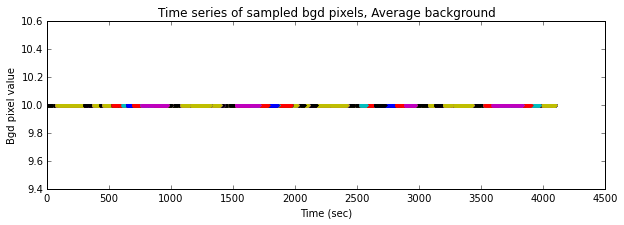

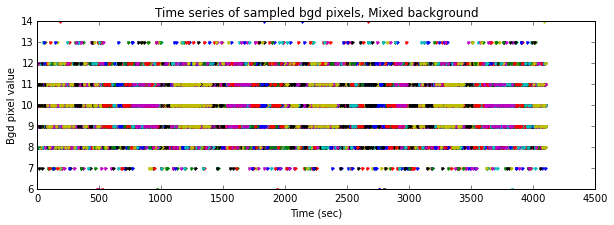

In [17]:
plot_bgd_px_series(t_ba, text=', Average background')
plot_bgd_px_series(t_m, text=', Mixed background')

4.40
4.40
10.16
10.16


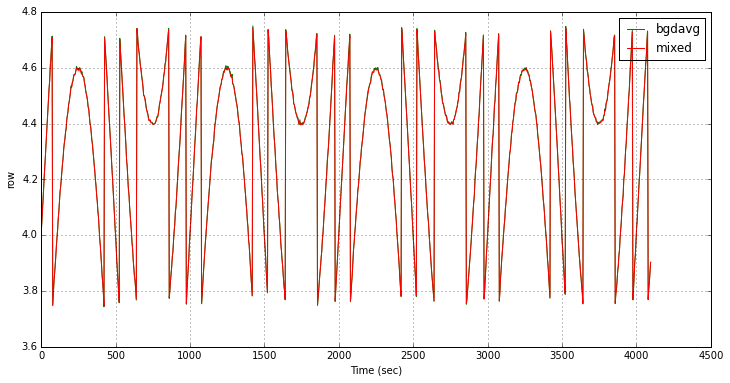

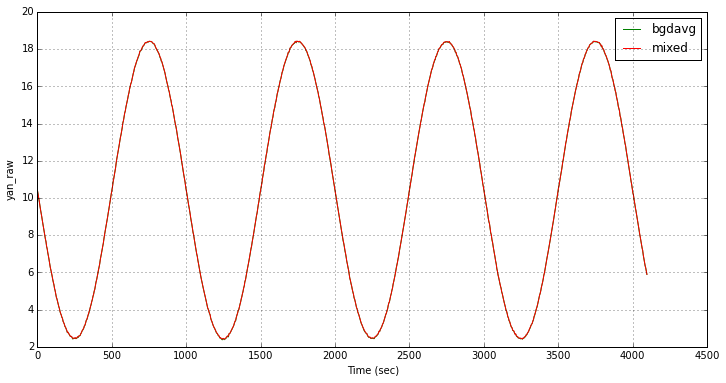

In [18]:
plot_coords([t_ba, t_m], 'row')
plot_coords([t_ba, t_m], 'yan_raw')

__Simulation of a 10.2 mag star with constant background and 1 hot pixel__

In [19]:
# Simulate hot pixels
def simulate_hot_pixels(times, hp_number, hp_val):

    row0, col0 = get_row0_col0(t_m['time'][0])
    img_size = 8
    row_min = shift + row0.min()
    row_max = shift + img_size + row0.max()
    col_min = shift + col0.min()
    col_max = shift + img_size + col0.max()

    print row_min, row_max, col_min, col_max

    np.random.seed(42)
    hp_rows = np.random.randint(row_min, row_max, size=hp_number)
    np.random.seed(24)
    hp_cols = np.random.randint(col_min, col_max, size=hp_number)

    hot_pixels = {}

    for rr, cc in zip(hp_rows, hp_cols):
        hot_pixels[(rr, cc)] = hp_val

    return hot_pixels

In [20]:
hp_number = 3
hp_val = 500
#hot_pixels = simulate_hot_pixels(t_m['time'][0], hp_number, hp_val)

# Test with only one hot pixel
hot_pixels = {(518, 518):500}

print hot_pixels

{(518, 518): 500}


In [21]:
slots = [0]

In [22]:
bgd = 'bgdavg'
np.random.seed(42)
rows_ba_hp = centroids(slots, img_size, bgd=bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_ba_hp = Table(rows_ba_hp)

Slot = 0


In [23]:
bgd = 'mixed'
np.random.seed(42)
rows_m_hp = centroids(slots, img_size, bgd=bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_m_hp = Table(rows_m_hp)

Slot = 0


In [24]:
yaw, pitch = get_yaw_pitch(t_m_hp['time'][0])
row0, col0 = get_row0_col0(t_m_hp['time'][0])

print np.sum(yaw - row0 > 1), np.sum(pitch - col0 > 1)

0 0


Row0, Col0 indicated in the titles


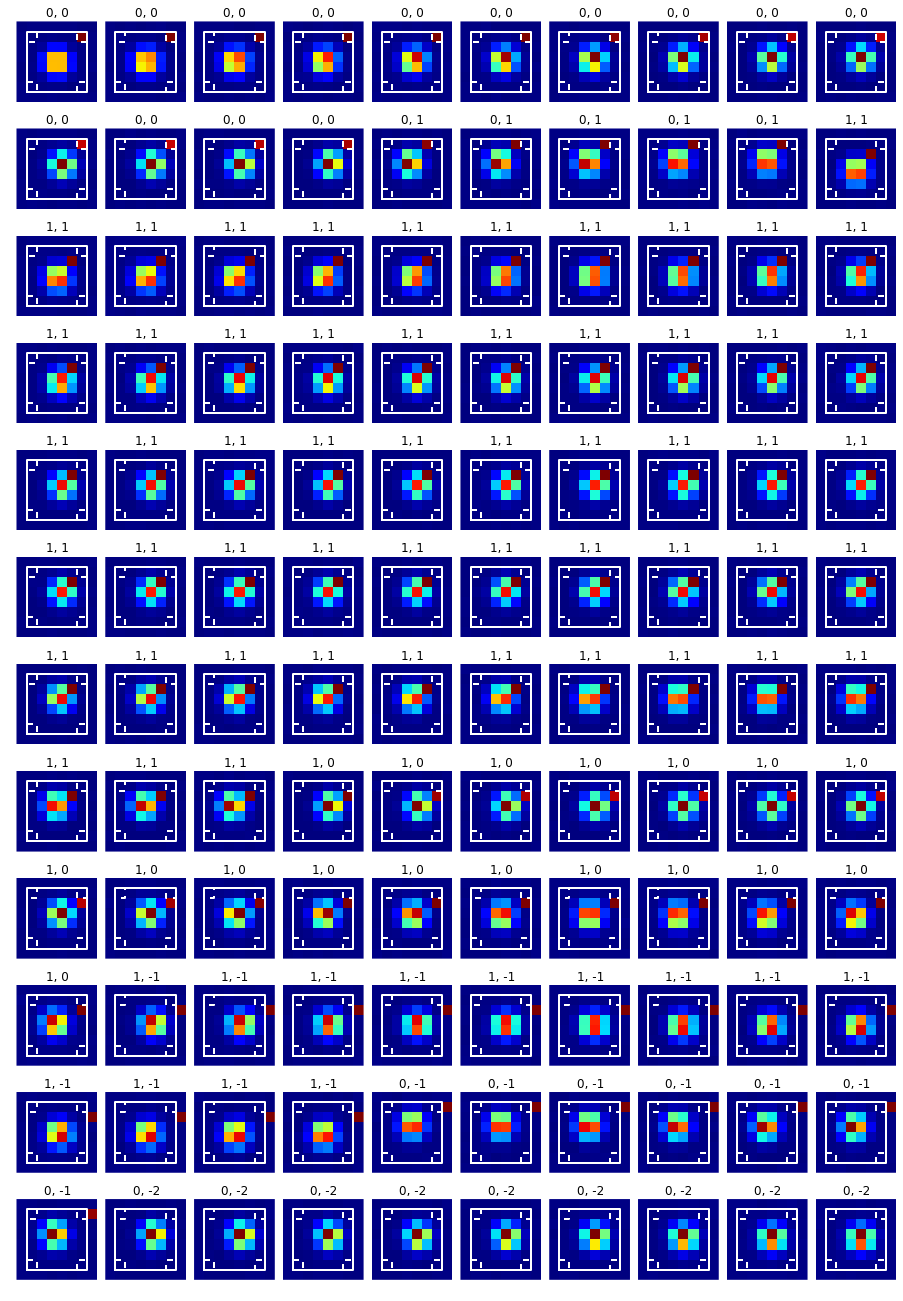

In [25]:
# Plot sequence of the first 120 images, notice the hot pixel in the upper right corner
fig = plt.figure(figsize=(13, 25))
for i, aa in enumerate(t_ba_hp['imgraw'][0][0:120]):
    plt.subplot(12, 10, i + 1)
    plot_star_image(aa.reshape(8, 8))
    plt.title('{}, {}'.format(t_ba_hp['row0'][0][i], t_ba_hp['col0'][0][i]))
    plt.axis('off')
print 'Row0, Col0 indicated in the titles'
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.1)

4.44
4.41
9.45
10.16


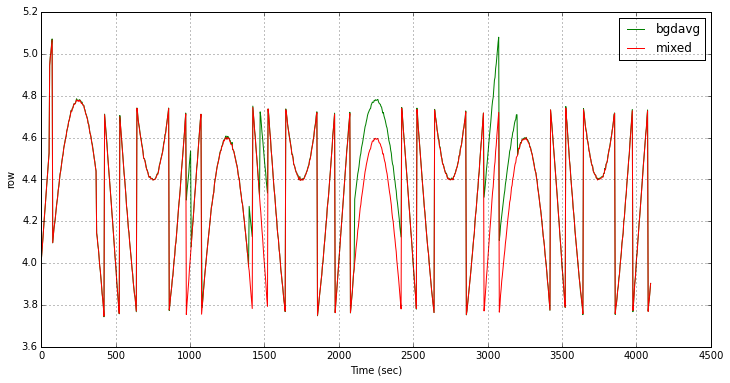

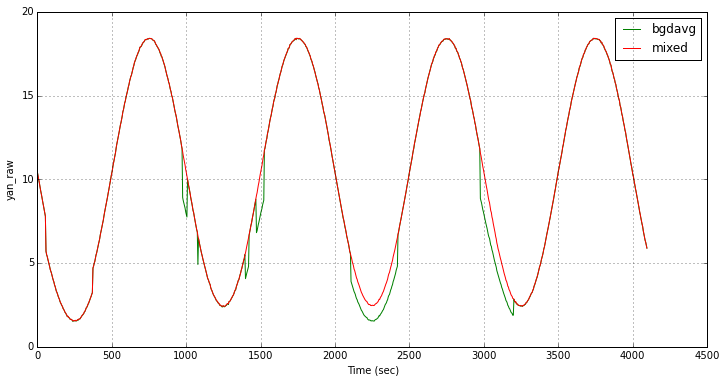

In [26]:
plot_coords([t_ba_hp, t_m_hp], 'row')
plot_coords([t_ba_hp, t_m_hp], 'yan_raw')

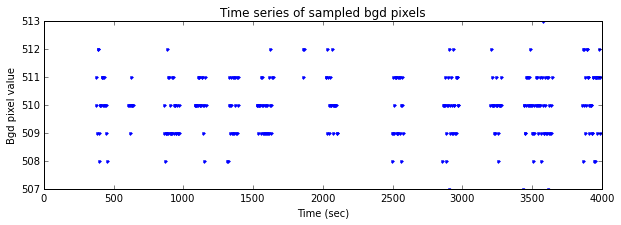

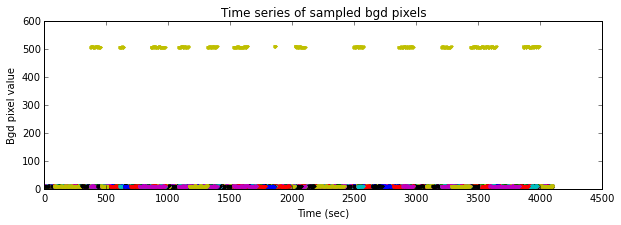

In [27]:
# Plot the time series of the hot pixel, and all bgd pixels
plot_bgd_px_series(t_m_hp, [(518, 518), (-518, -518)])
plot_bgd_px_series(t_m_hp)

In [28]:
# Repeat simulation for a bright star, 8.2 mag (no hot pixel)
bgd = 'mixed'
np.random.seed(42)
kwargs['mag'] = 8.2
rows_m_bri = centroids(slots, img_size, bgd=bgd, sim=True, **kwargs)
t_m_bri = Table(rows_m_bri)

Slot = 0


In [33]:
# Repeat simulation for a bright star, 8.2 mag (no hot pixel)
bgd = 'bgdavg'
np.random.seed(42)
kwargs['mag'] = 8.2
rows_ba_bri = centroids(slots, img_size, bgd=bgd, sim=True, **kwargs)
t_ba_bri = Table(rows_ba_bri)

Slot = 0


In [29]:
# Repeat simulation for a bright star, 8.2 mag (1 hot pixel)
bgd = 'mixed'
np.random.seed(42)
kwargs['mag'] = 8.2
rows_m_hp_bri = centroids(slots, img_size, bgd=bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_m_hp_bri = Table(rows_m_hp_bri)

Slot = 0


In [34]:
# Repeat simulation for a bright star, 8.2 mag (1 hot pixel)
bgd = 'bgdavg'
np.random.seed(42)
kwargs['mag'] = 8.2
rows_ba_hp_bri = centroids(slots, img_size, bgd=bgd, sim=True, hot_pixels=hot_pixels, **kwargs)
t_ba_hp_bri = Table(rows_ba_hp_bri)

Slot = 0


After t~500 sec, the hot pixel is sampled and included in the background image


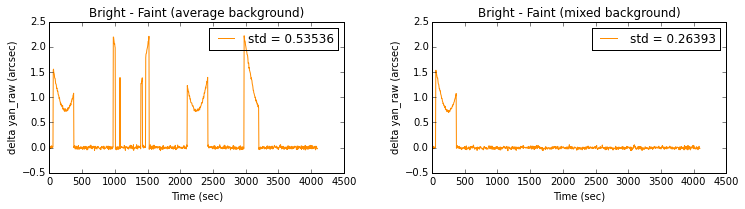

In [46]:
key = 'yan_raw'

fig = plt.figure(figsize=(10, 3))

ylim = (-0.5, 2.5)

plt.subplot(1, 2, 1)
d_ang = t_ba_hp_bri[key][0][0] - t_ba_hp[key][0][0]
plt.plot(t_m['time'][0], d_ang, color='Darkorange',
         label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
plt.xlabel('Time (sec)')
plt.ylabel('delta {} (arcsec)'.format(key))
plt.title('Bright - Faint (average background)')
plt.legend()

plt.subplot(1, 2, 2)
d_ang = t_m_hp_bri[key][0][0] - t_m_hp[key][0][0]
plt.plot(t_m['time'][0], d_ang, color='Darkorange',
         label='std = {:.5f}'.format(np.std(d_ang - np.median(d_ang))))
plt.xlabel('Time (sec)')
plt.ylabel('delta {} (arcsec)'.format(key))
plt.title('Bright - Faint (mixed background)')
plt.legend()
plt.ylim(ylim)

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.3, wspace=0.3)

print "After t~500 sec, the hot pixel is sampled and included in the background image"

__Example: real data__

In [39]:
# 50804, stars in all slots tracked, star in slot 7 faint, all other stars bright
obsid = 50804
dwell = events.dwells.filter(obsid=obsid)[0]
slots = range(8)

In [40]:
bgd = 'bgdavg'
rows_data_ba = centroids(slots, img_size, bgd=bgd, sim=False)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [41]:
bgd = 'mixed'
rows_data_m = centroids(slots, img_size, bgd=bgd, sim=False)

Slot = 0
Slot = 1
Slot = 2
Slot = 3
Slot = 4
Slot = 5
Slot = 6
Slot = 7


In [42]:
t_data_ba = Table(rows_data_ba)
t_data_m = Table(rows_data_m)

Method: average background subtraction


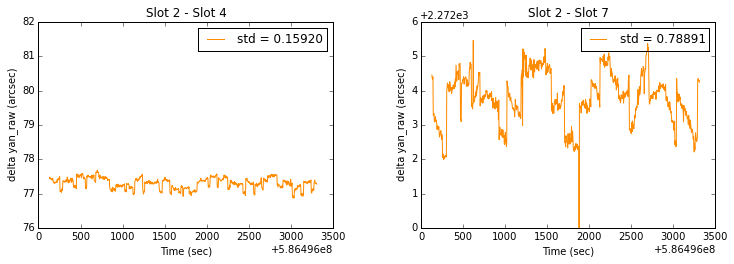

In [43]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_data_ba)
print "Method: average background subtraction"

Method: mixed background


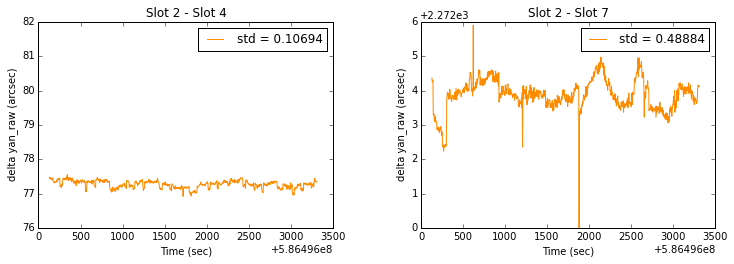

In [44]:
dt = [0, -2.05] # shift in sec between time axes for slot pairs (2, 4) and (2, 7)
key = 'yan_raw'
plot_d_ang(key, dt, t_data_m)
print "Method: mixed background"

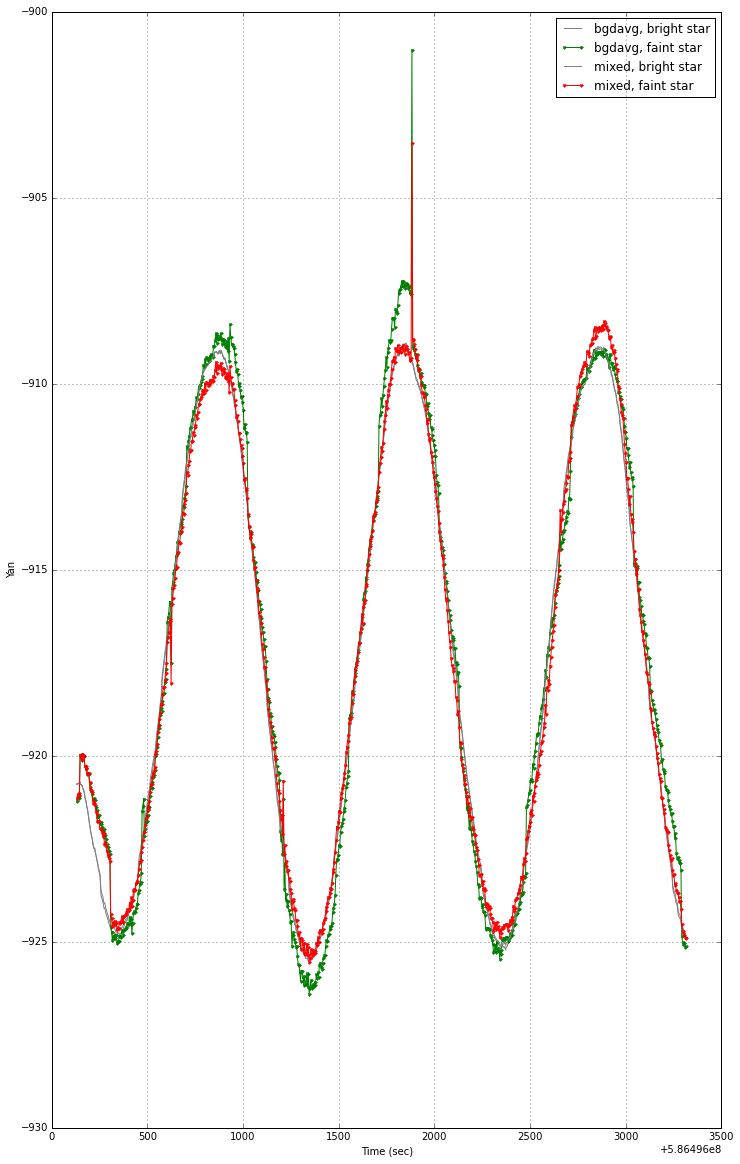

In [45]:
fig = plt.figure(figsize=(12, 20))
color = ['green', 'red']
method = ['bgdavg', 'mixed']
for i, t in enumerate([t_data_ba, t_data_m]):
    plt.plot(t['time'][2], t['yan_raw'][2][0] - 2276, color='gray',
             label=method[i] +', bright star')
    plt.plot(t['time'][7], t['yan_raw'][7][0], color=color[i], marker='.',
             label=method[i] +', faint star')
plt.ylabel("Yan")
plt.xlabel("Time (sec)")
plt.grid()
plt.legend()

In [ ]:
# Test: min/max row/col number sampled by dither

keys =  t_m[0]['bgd_px_series'].keys()
abs_rows = []
abs_cols = []
for i, key in enumerate(keys):
    if i % 2 == 0:
        abs_rows.append(key[0])
        abs_cols.append(key[1])
print np.min(abs_rows), np.max(abs_rows)
print np.min(abs_cols), np.max(abs_cols)